In [12]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import optimizers
from pathlib import Path
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sn
import os
import io
import pickle
import random
import itertools
from importnb import Notebook, reload
with Notebook(): 
    import Utilities

In [2]:
config = {
    'start_date': '2006-10-20',
    'end_date': '2013-11-19',
    'lookback': 1,    # Lookback is set to 1 since we only consider one previous day here
    'delay': 5,
    'p': 1,
    'd': 1,
    'q': 1,
    'series': '1 YEAR',
}

In [3]:
# Load data 
news_path = Path("../Datasets/data/financial_headlines_20061020-20131119.pkl")
news_data = pd.DataFrame(pd.read_pickle(news_path))
news_data.set_index('date',inplace=True)
# Concatinate daily 
text = Utilities.preprocess_text(news_data)

In [4]:
# Create a matrix of size (n,vocab_size)
count_vec = CountVectorizer()
count_vec.fit(text)
x_count = count_vec.transform(text)

tfidf_vec = TfidfTransformer()
tfidf_vec.fit(x_count)
x_tf = tfidf_vec.transform(x_count)
print("Shape of x:",x_tf.shape)

Shape of x: (2582, 23560)


In [5]:
y = Utilities.load_direction_labels(config)

In [6]:
# Remove last row of the x-matrix, since there's no label for that entry
if x_tf.shape[0] != len(y): 
    x_tf = x_tf[:-1]


In [7]:
# Shuffle for training and testing 
(x_train,y_train), (x_test, y_test) = Utilities.shuffle_and_partition(x_tf.todense(),y, test_part=0.2)
print("Shape of x_train: ",x_train.shape)
print("Shape of y_train: ",y_train.shape)

Shape of x_train:  (2064, 23560)
Shape of y_train:  (2064,)


In [8]:
def create_nn(n_nodes, lr=0.001):
    # n_nodes is a list with the number of nodes per layer, starting from the input 
    model = Sequential()
    model.add(Dense(n_nodes[0], activation='relu', input_shape=[x_train.shape[-1]]))
    if len(n_nodes) > 1:
        for n in n_nodes:
            model.add(Dense(n,activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    rms = optimizers.RMSprop(learning_rate=lr)
    model.compile(optimizer=rms, loss='binary_crossentropy', metrics=['acc'])
    return model

def train_and_format(x,y,bs,epochs, results, layers, nodes,lr,verbose=0):
    name = f"{bs}_{layers}_{nodes}"
    temp_history = model.fit(x, y, batch_size=bs, validation_split=0.2, epochs = epochs,verbose=verbose)
    return results.append(pd.Series([np.mean(temp_history.history['val_acc'][-5:]),
                                                temp_history, model, layers,
                                                nodes, bs, lr],
                                                name=name,
                                    index=['Mean Val Acc','History','Model','Layers','Nodes','Batch Size','Learning Rate']))


In [9]:
n_layers = [2]
n_nodes = [25, 50, 100, 200]
learning_rates = [0.0001]
batch_sizes = [12]
epochs = 20
verbose = 0
results = pd.DataFrame(columns=['Mean Val Acc','History','Model', 'Layers', 'Nodes','Batch Size','Learning Rate'])
n_configs = sum([len(n_nodes)**l for l in n_layers]) * len(batch_sizes) * len(learning_rates)
ctr = 0
print('Testing {} combinations. '.format(n_configs))
for layers in n_layers:
    if layers == 1: node_configs = list(itertools.product(n_nodes))
    elif layers == 2: node_configs = list(itertools.product(n_nodes, n_nodes))
    elif layers == 3: node_configs = list(itertools.product(n_nodes, n_nodes, n_nodes))
    elif layers == 4: node_configs = list(itertools.product(n_nodes, n_nodes, n_nodes, n_nodes))
    for bs in batch_sizes: 
        for temp_nodes in node_configs:
            for lr in learning_rates: 
                ctr += 1 
                model = create_nn(temp_nodes, lr)
                results = train_and_format(x_train, y_train, bs, epochs, results, layers, temp_nodes, lr, verbose)
                print("{} %     ".format(round(100 * ctr / n_configs,2)),end='\r')
            
            

Testing 16 combinations. 


In [10]:
k = 5
print("Top {} configs: ".format(k))
k_best = np.argpartition(results['Mean Val Acc'],-k)[-k:]
results.iloc[k_best]

Top 5 configs: 


,Mean Val Acc,History,Model,Layers,Nodes,Batch Size,Learning Rate
"12_2_(25, 200)",0.657627,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...,2,"(25, 200)",12,0.0001
"12_2_(25, 50)",0.659080,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...,2,"(25, 50)",12,0.0001
"12_2_(50, 25)",0.666344,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...,2,"(50, 25)",12,0.0001
"12_2_(25, 100)",0.667797,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...,2,"(25, 100)",12,0.0001
"12_2_(25, 25)",0.689104,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...,2,"(25, 25)",12,0.0001


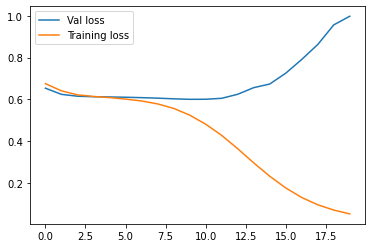

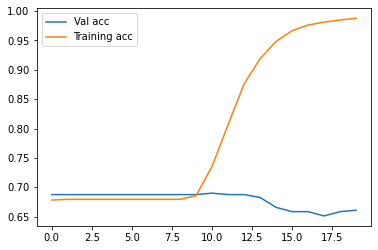

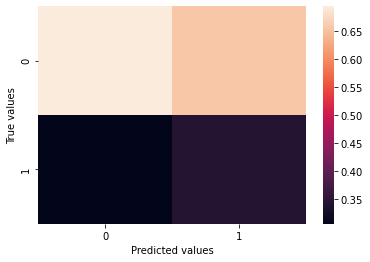

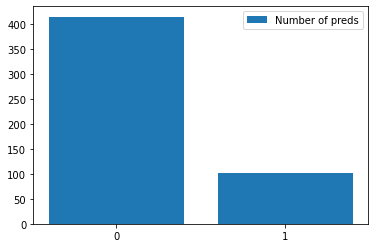

              precision    recall  f1-score   support

         0.0       0.69      0.81      0.75       355
         1.0       0.34      0.22      0.27       162

    accuracy                           0.62       517
   macro avg       0.52      0.51      0.51       517
weighted avg       0.58      0.62      0.60       517

12_2_(25, 200)


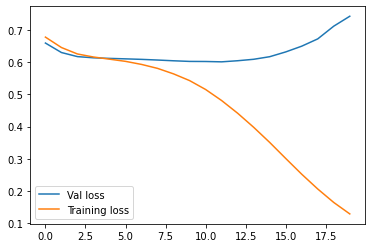

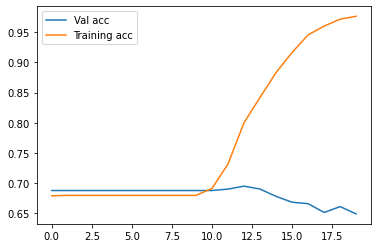

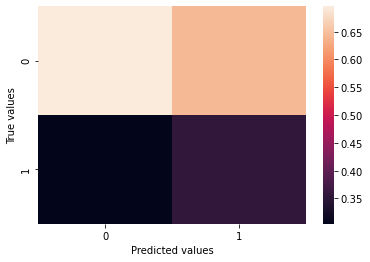

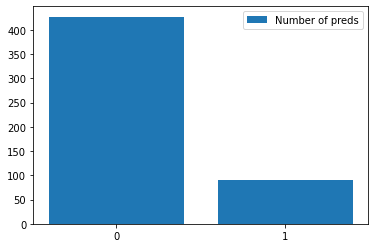

              precision    recall  f1-score   support

         0.0       0.70      0.84      0.76       355
         1.0       0.36      0.20      0.25       162

    accuracy                           0.64       517
   macro avg       0.53      0.52      0.51       517
weighted avg       0.59      0.64      0.60       517

12_2_(25, 50)


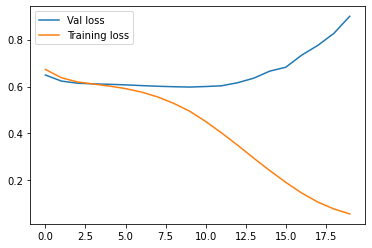

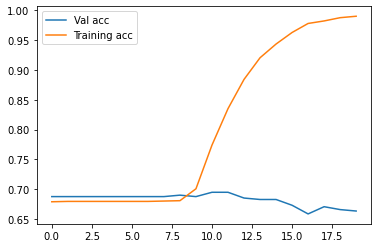

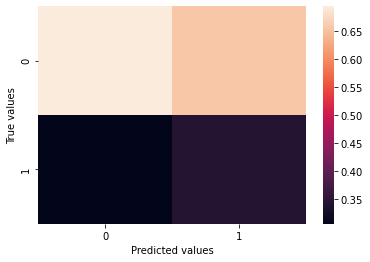

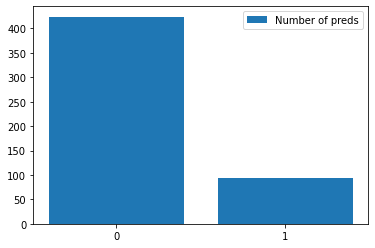

              precision    recall  f1-score   support

         0.0       0.69      0.83      0.75       355
         1.0       0.34      0.20      0.25       162

    accuracy                           0.63       517
   macro avg       0.52      0.51      0.50       517
weighted avg       0.58      0.63      0.60       517

12_2_(50, 25)


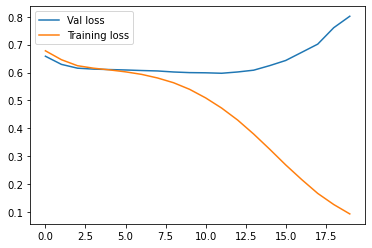

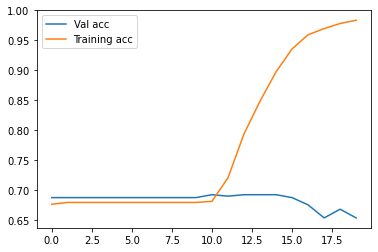

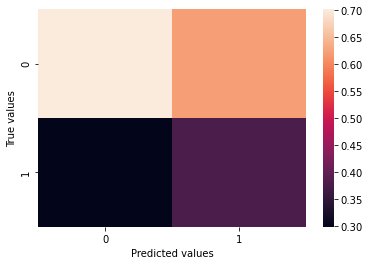

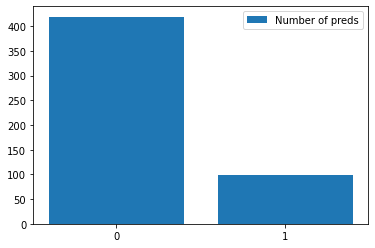

              precision    recall  f1-score   support

         0.0       0.70      0.83      0.76       355
         1.0       0.38      0.23      0.28       162

    accuracy                           0.64       517
   macro avg       0.54      0.53      0.52       517
weighted avg       0.60      0.64      0.61       517

12_2_(25, 100)


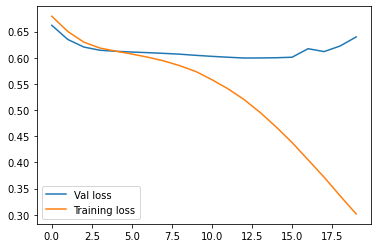

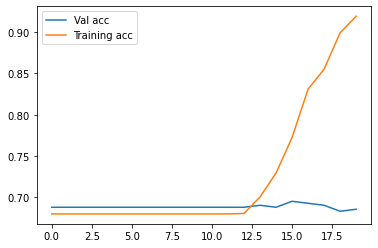

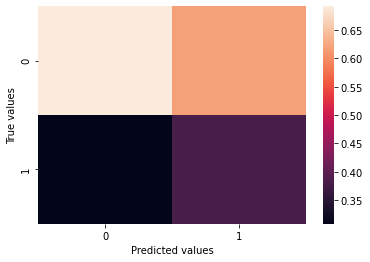

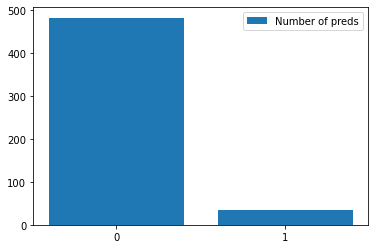

              precision    recall  f1-score   support

         0.0       0.69      0.94      0.80       355
         1.0       0.38      0.08      0.13       162

    accuracy                           0.67       517
   macro avg       0.54      0.51      0.46       517
weighted avg       0.59      0.67      0.59       517

12_2_(25, 25)


In [22]:
for i in k_best: 
    plt.plot(results.iloc[i]['History'].history['val_loss'],label='Val loss')
    plt.plot(results.iloc[i]['History'].history['loss'],label='Training loss')
    plt.legend()
    plt.show()
    plt.plot(results.iloc[i]['History'].history['val_acc'],label='Val acc')
    plt.plot(results.iloc[i]['History'].history['acc'],label='Training acc')
    plt.legend()
    plt.show()
    model = results.iloc[i]['Model']
    model.evaluate(x_test,y_test,verbose=0)
    y_test_pred = np.round(model.predict(x_test))
    conf_mat = confusion_matrix(y_test,y_test_pred,normalize='pred')
    ax = sn.heatmap(conf_mat,)
    ax.set_ylabel("True values")
    ax.set_xlabel("Predicted values")
    plt.show()
    y_sums = np.zeros(2)
    y_sums[0] = sum(y_test_pred == 0)
    y_sums[1] = sum(y_test_pred == 1)
    plt.bar([0,1],y_sums,label='Number of preds')
    plt.xticks([0,1])
    plt.legend()
    plt.show()
    print(classification_report(y_test, y_test_pred))
    print(results.index[i])
